## Imports

In [ ]:
# !pip3 install openai==0.27.0 --quiet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import openai
from google.colab import userdata

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re
import time
import json
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


In [ ]:
DATA_PATH = ""

FA = "2"
PROMPT_PATH = ""
RESULTS_PATH = ""

SEED = 312
N_BOOTSTRAP = 5000

In [ ]:
JUDGE_MODEL = "o3-2025-04-16"
openai.api_key = userdata.get("")

model_ids = [model.id for model in openai.Model.list().data]
assert JUDGE_MODEL in model_ids

## Data

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df[df["Role"]=="assistant"]
df = df[df["Assessment ID"]==int(FA)]
df = df.rename(columns={'XYZ ID':'student','Assessment ID':'assessment',\
                        'Conversation No.': 'turn','Role':'role','Response':'utterance'})
df = df.drop(columns=["Version"])
df = df.reset_index(drop=True)

assert not df.isnull().values.any()

assert df['student'].dtype == 'object'
assert df['student'].apply(lambda x: bool(re.fullmatch(r'XYZ25\d{3}', str(x)))).all()
assert df['assessment'].dtype == int
assert set(df['assessment'].unique()) == {int(FA)}
assert df['turn'].dtype == int
assert all(df['turn'] % 2)
assert df['role'].dtype == 'object'
assert set(df['role'])=={'assistant'}
assert df['utterance'].dtype == 'object'

df.head()

## Prompt

In [ ]:
with open(PROMPT_PATH, 'r', encoding='utf-8') as f:
    prompt = f.read()

prompt

'You are a learning science researcher whose job it is to determine if a pedagogical agent\'s feedback to students promotes goal-setting behavior in the student, as defined by Bandura, by identifying the degree to which the agent\'s most recent utterance encourages the student to take actionable next steps.\n\nPreviously, students were asked the following formative assessment question:\n\n"Write down each rule (recall the IF and THEN multiple choice from today for each category of rainfall)."\n\nThere are three rules the students were required to identify:\n1. If rainfall is less than absorption limit, set absorption to rainfall and set runoff to 0.\n2. If rainfall is equal to absorption limit, set absorption to either rainfall or absorption limit, and set runoff to 0.\n3. If rainfall is greater than absorption limit, set absorption to absorption limit and set runoff to either rainfall - absorption limit or rainfall - absorption.\n\nTheir formative assessment responses were then graded

## API Call

In [ ]:
def get_openai_response(messages):
  start_time = time.time()
  response = openai.ChatCompletion.create(
      model=JUDGE_MODEL,
      messages=messages,
      response_format={ "type": "json_object" },
      seed=SEED)
  total_time = time.time()-start_time
  total_tokens = response["usage"]["total_tokens"]
  generation = response["choices"][0]["message"]["content"].strip()

  return generation, total_time, total_tokens

In [ ]:
response = get_openai_response([{"role":"system","content":"Confirm that the api is working. Respond using the following JSON schema: {'working':bool, 'explanation':str}"}])
print(response)

('{"working": true, "explanation": "The API responded successfully."}', 5.627178907394409, 257)


## Generations

In [ ]:
results = [["messages","generation","total_time_s","total_tokens","explanation","goal_setting_score"]]

for idx,row in df.iterrows():
    agent_str = "Agent: "+row['utterance']
    messages = [{"role":"system","content":prompt},{"role":"user","content":agent_str}]

    generation, total_time, total_tokens = get_openai_response(messages)
    parsed_generation = json.loads(generation)

    explanation = parsed_generation["explanation"]
    goal_setting_score = parsed_generation["goal_setting_score"]

    results.append([messages,generation,total_time,total_tokens,explanation,goal_setting_score])

    print(f"FINISHED UTTERANCE {idx}.")

FINISHED UTTERANCE 0.
FINISHED UTTERANCE 1.
FINISHED UTTERANCE 2.
FINISHED UTTERANCE 3.
FINISHED UTTERANCE 4.
FINISHED UTTERANCE 5.
FINISHED UTTERANCE 6.
FINISHED UTTERANCE 7.
FINISHED UTTERANCE 8.
FINISHED UTTERANCE 9.
FINISHED UTTERANCE 10.
FINISHED UTTERANCE 11.
FINISHED UTTERANCE 12.
FINISHED UTTERANCE 13.
FINISHED UTTERANCE 14.
FINISHED UTTERANCE 15.
FINISHED UTTERANCE 16.
FINISHED UTTERANCE 17.
FINISHED UTTERANCE 18.
FINISHED UTTERANCE 19.
FINISHED UTTERANCE 20.
FINISHED UTTERANCE 21.
FINISHED UTTERANCE 22.
FINISHED UTTERANCE 23.
FINISHED UTTERANCE 24.
FINISHED UTTERANCE 25.
FINISHED UTTERANCE 26.
FINISHED UTTERANCE 27.
FINISHED UTTERANCE 28.
FINISHED UTTERANCE 29.
FINISHED UTTERANCE 30.
FINISHED UTTERANCE 31.
FINISHED UTTERANCE 32.
FINISHED UTTERANCE 33.
FINISHED UTTERANCE 34.
FINISHED UTTERANCE 35.
FINISHED UTTERANCE 36.
FINISHED UTTERANCE 37.
FINISHED UTTERANCE 38.
FINISHED UTTERANCE 39.
FINISHED UTTERANCE 40.
FINISHED UTTERANCE 41.
FINISHED UTTERANCE 42.
FINISHED UTTERANCE 43

## Save

In [ ]:
df_results = pd.DataFrame(results[1:], columns=results[0])
df = pd.concat([df, df_results], axis=1)
df.to_csv(RESULTS_PATH, index=False)

## EDA

In [ ]:
df_results = pd.read_csv(RESULTS_PATH)
df_results = df_results[df_results["assessment"]==int(FA)]
df_results.head()

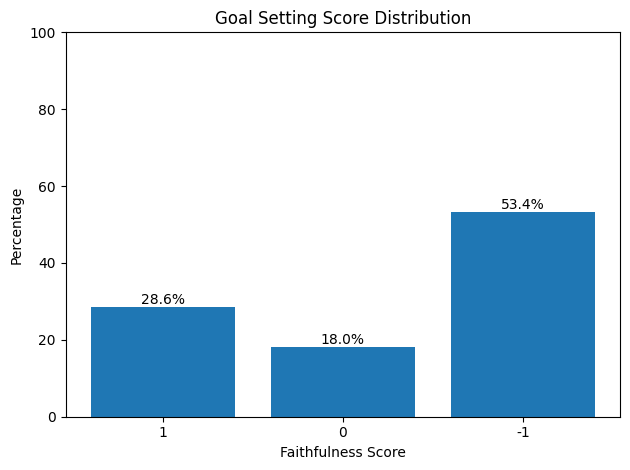

In [4]:
col = "goal_setting_score"

pct = (
  df_results[col]
  .value_counts(normalize=True)
  .reindex([1, 0, -1], fill_value=0)
  .mul(100)
)

plt.figure()
bars = plt.bar(pct.index.astype(str), pct.values)
plt.title(f"{col.replace('_', ' ').title()} Distribution")
plt.xlabel("Faithfulness Score")
plt.ylabel("Percentage")

for bar, value in zip(bars, pct.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.1f}%",
        ha="center",
        va="bottom",
    )

plt.ylim(0, 100)
plt.tight_layout()

## Confidence Intervals

In [5]:
boot_goal_setting_yes  = []
boot_goal_setting_no = []

values = df_results["goal_setting_score"].to_numpy()

rng = np.random.default_rng(seed=SEED)

for _ in range(N_BOOTSTRAP):
    resample = rng.choice(values, size=len(df_results), replace=True)
    boot_goal_setting_yes.append((resample ==  1).mean())
    boot_goal_setting_no.append((resample == -1).mean())

goal_setting_yes_low, goal_setting_yes_high  = np.percentile(boot_goal_setting_yes, [2.5, 97.5])
goal_setting_no_low, goal_setting_no_high = np.percentile(boot_goal_setting_no, [2.5, 97.5])

win_moe  = (goal_setting_yes_high-goal_setting_yes_low) / 2
loss_moe = (goal_setting_no_high-goal_setting_no_low) / 2

p_cons   = (values ==  1).mean()
p_incons = (values == -1).mean()

print(f"Goal setting (1):    {p_cons*100:.2f} ± {win_moe*100:.2f}  (95 % CI)")
print(f"Not goal setting (-1): {p_incons*100:.2f} ± {loss_moe*100:.2f}  (95 % CI)")

Goal setting (1):    28.59 ± 2.46  (95 % CI)
Not goal setting (-1): 53.38 ± 2.74  (95 % CI)
